## Vehicle Detection

---

** Project Goals **

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Imports

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### Load Training Images

In [2]:
cars = glob.glob('vehicles/**/*.png')
noncars = glob.glob('non-vehicles/**/*.png')

print('Car images:', len(cars))
print('Non-Car images:', len(noncars))

Car images: 8792
Non-Car images: 8968


### Method to get HOG features
*Method taken from lesson on scikit HOG features*

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), 
                      transform_sqrt=True, 
                      visualise=vis, feature_vector=feature_vec)
        return features

### HOG Features on example images

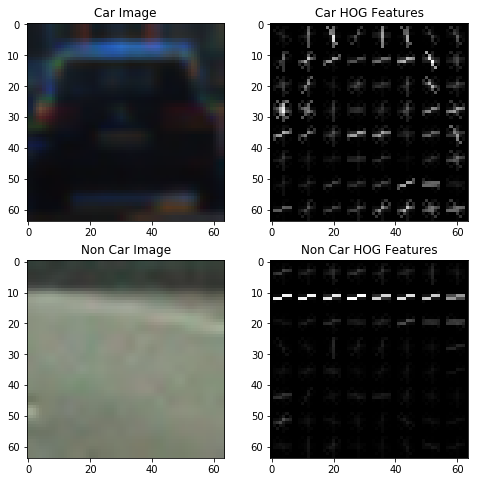

In [4]:
car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
noncar_img = mpimg.imread(noncars[np.random.randint(0,len(noncars))])
_, car_vis = get_hog_features(car_img[:,:,0], 9, 8, 2, vis=True)
_, noncar_vis = get_hog_features(noncar_img[:,:,0], 9, 8, 2, vis=True)
f, axs = plt.subplots(2,2, figsize=(8,8))
axs[0,0].imshow(car_img)
axs[0,0].set_title("Car Image")
axs[0,1].imshow(car_vis, cmap='gray')
axs[0,1].set_title("Car HOG Features")
axs[1,0].imshow(noncar_img)
axs[1,0].set_title("Non Car Image")
axs[1,1].imshow(noncar_vis, cmap='gray')
axs[1,1].set_title("Non Car HOG Features")
plt.show()

### Define method to get binned features
*Method taken from lesson on spatial binning*

In [5]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Define a function to compute color histogram features  
*Method taken from lesson on histograms of color*

In [6]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    # bin_edges = rhist[1]
    # bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    # return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

### Define extract features method

In [7]:
def extract_features(imgs, cspace='RGB',  
                     hist_feat=True, hist_bins=32, 
                     spatial_feat=True, spatial_size=(32,32),
                     hog_feat=True, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features=[]
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      
        
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
            
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            img_features.append(hog_features)
            
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

### Parameters to tweak

In [17]:
# YCrCb gave the highest test accuracy
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

### Extract features from the dataset

In [18]:
t1=time.time()
car_features = extract_features(cars, cspace=color_space, 
                                hist_feat=hist_feat, hist_bins=hist_bins,
                                spatial_feat=spatial_feat, spatial_size=spatial_size,
                                hog_feat=hog_feat, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(noncars, cspace=color_space, 
                                   hist_feat=hist_feat, hist_bins=hist_bins,
                                   spatial_feat=spatial_feat, spatial_size=spatial_size,
                                   hog_feat=hog_feat, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
diff = t2-t1;
avg = diff/(len(cars)+len(noncars))
print('Time to extract features:', round(diff, 2), 'sec')
print('Avg extraction time per image:', round(avg, 4), 'sec')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(car_features[0]))

Time to extract features: 89.2 sec
Avg extraction time per image: 0.005 sec
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


### Split data into training and test set

In [19]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Save some memory :|
# del car_features, notcar_features

# shuffle
X, y = shuffle(X, y)

rand_state = np.random.randint(0, 100)
# split
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

In [20]:
# fit scalar on training data
X_scaler = StandardScaler().fit(X)
# Scale both training and test data
X_train = X_scaler.transform(X_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)

# Save some more memory :D
# del X, y, X_train_unscaled, X_test_unscaled

### Fit a Linear classifier

In [21]:
svc = LinearSVC()

# time the classifier
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print('Time to train:',round(t2-t1, 2), 'sec')

print('Test accuracy:', round(svc.score(X_test, y_test), 4))

model_info = { 'svc':svc, 'X_scaler':X_scaler}
pickle.dump(model_info, open("model_info.p", "wb"))

Time to train: 4.86 sec
Test accuracy: 0.9876


### Convenience functions
*Taken from lessons*

In [32]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Single function to find cars

In [33]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    # rectangles where cars found
    ractangles = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                ractangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return ractangles

### Test on sample image

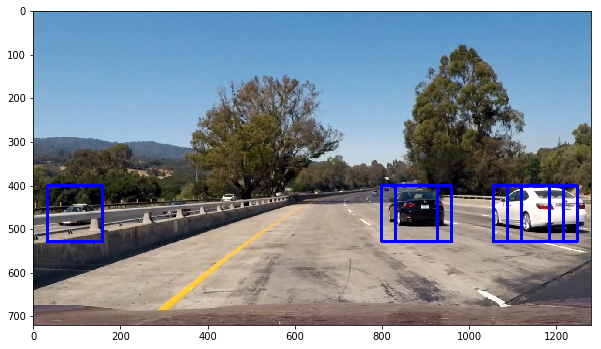

In [34]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = None
scale = 2

boxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

car_boxes = draw_boxes(test_img, boxes)
plt.figure(figsize=(10,10))
plt.imshow(car_boxes)
plt.show()

### Heatmap and SciPy labels

To help in reducing false positives

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

### Single method to process a frame

In [36]:
ystart = 400
ystop = None
scales = [1.1, 1.5, 1.9, 2.3]
heatmap_threshold = 2
def process_frame(img):
    draw_img = np.copy(img)
    boxes = []
    # Move inside find cars
    for scale in scales:
        rects = find_cars(img, ystart, ystop, scale, svc, X_scaler, 
                          orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxes.extend(rects)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, heatmap_threshold)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(draw_img, labels)
    return draw_img
    

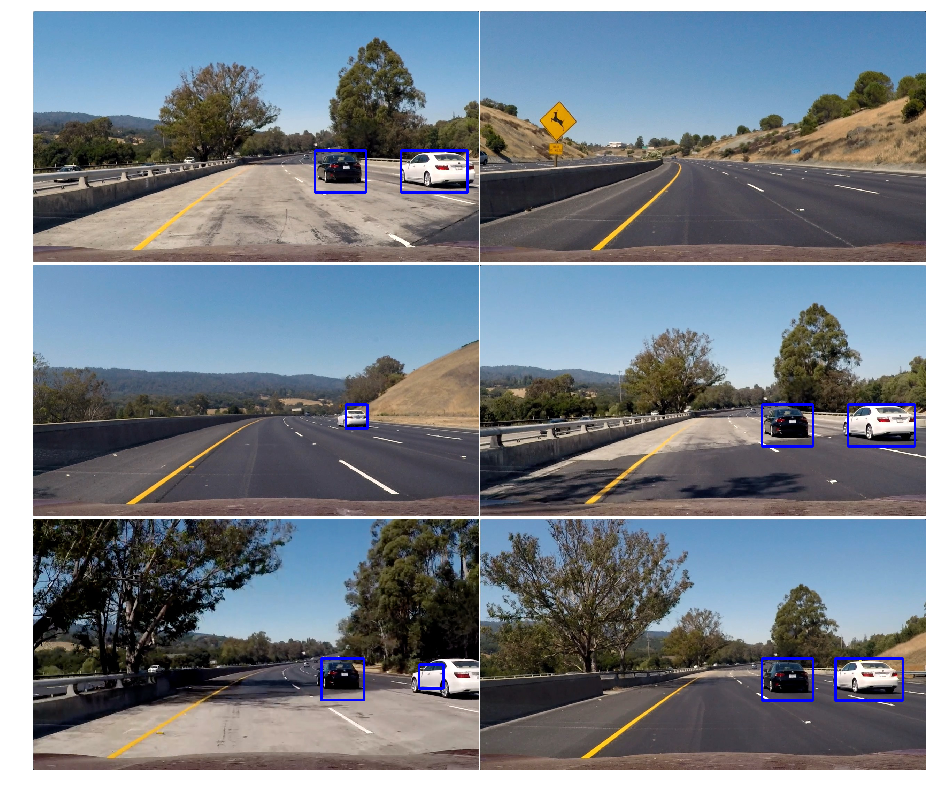

In [37]:
test_images = glob.glob('./test_images/test*.jpg')

frame_out =  process_frame(test_img)
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


### Test Video

In [38]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:07<00:01,  1.76s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 1min 8s


In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

### Project Video

In [40]:
project_out_file = 'project_video_out.mp4'
clip_project = VideoFileClip('project_video.mp4')
clip_project_out = clip_project.fl_image(process_frame)
%time clip_project_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [37:38<00:01,  1.79s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 37min 39s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out_file))